# [DLthon] 오늘의 계획
- 모델 최적화 (W&B 활용)
- Data별 결과 분석

# 선정 모델: EfficientNetB0

In [92]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

# W&B 설정
import wandb
from wandb.keras import WandbMetricsLogger

In [93]:
!pip install wandb

In [94]:
# 키 파일 경로
key_file_path = "./wandb/wandb_key.txt"

# 파일에서 W&B 키 불러오기
with open(key_file_path, "r") as f:
    YOUR_WANDB_KEY = f.read().strip()  # 공백 제거

# W&B 로그인
wandb.login(key=YOUR_WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [95]:
# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

In [96]:
# W&B Sweep 설정 (하이퍼파라미터 검색)
sweep_config = {
    "method": "random",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [1e-5, 5e-5, 1e-4]},
        "batch_size": {"values": [16, 32, 64]},
        "dropout_rate": {"values": [0.2, 0.3, 0.5]},
        "epochs": {"values": [10, 20, 30]},
    },
}

## 1. Dense 256

### 1-1. sweep ID: ruz6xr87

In [114]:
# Sweep 불러오기
sweep_id = "ruz6xr87"  # Sweep ID
sweep = api.sweep(f"{entity_name}/{project_name}/{sweep_id}")

# 최적의 실험 찾기 (validation accuracy 기준)
best_run = max(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0))

# ✅ 최적의 모델 이름
print(f"📌 최적 모델 이름: {best_run.name}")

# ✅ 최적의 하이퍼파라미터 출력
best_params = best_run.config
print(f"\n✅ 최적의 하이퍼파라미터:\n {best_params}")

# ✅ 최적의 모델 성능 출력 (loss, accuracy 등)
best_metrics = best_run.summary
print("\n✅ 최적의 모델 성능:")

# Loss 값은 그대로 출력
print(f"Loss: {best_metrics.get('loss', 'N/A')}")
print(f"Validation Loss: {best_metrics.get('val_loss', 'N/A')}")

# Accuracy 값을 퍼센트로 변환
accuracy = best_metrics.get('accuracy', None)
val_accuracy = best_metrics.get('val_accuracy', None)

if accuracy is not None:
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("Accuracy: N/A")

if val_accuracy is not None:
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
else:
    print("Validation Accuracy: N/A")

📌 최적 모델 이름: valiant-sweep-4

✅ 최적의 하이퍼파라미터:
 {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 5e-05}

✅ 최적의 모델 성능:
Loss: 0.05427800118923187
Validation Loss: 0.7077760696411133
Accuracy: 99.05%
Validation Accuracy: 82.05%


### 1-2. sweep ID: 8twrl8wu

In [97]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish-classification")

Create sweep with ID: 8twrl8wu
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish-classification/sweeps/8twrl8wu


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: d66x7tx7 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 5e-05


Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Epoch 1/20
14/14 [==============================] - 21s 950ms/step - loss: 1.8083 - accuracy: 0.2104 - val_loss: 1.8050 - val_accuracy: 0.0769
Epoch 2/20
14/14 [==============================] - 12s 812ms/step - loss: 1.5942 - accuracy: 0.3759 - val_loss: 1.6843 - val_accuracy: 0.2308
Epoch 3/20
14/14 [==============================] - 12s 799ms/step - loss: 1.4023 - accuracy: 0.5366 - val_loss: 1.5629 - val_accuracy: 0.4103
Epoch 4/20
14/14 [==============================] - 12s 823ms/step - loss: 1.2407 - accuracy: 0.6336 - val_loss: 1.4368 - val_accuracy: 0.5128
Epoch 5/20
14/14 [==============================] - 12s 793ms/step - loss: 1.0797 - accuracy: 0.6986 - val_loss: 1.2989 - val_accuracy: 0.6410
Epoch 6/20
14/14 [==============================] - 12s 811ms/step - loss: 0.9448 - accuracy: 0.7671 - val_loss: 1.1831 - val_accuracy: 0.6410
Epoch 7/20
14/14 [==============================] - 12s 805ms

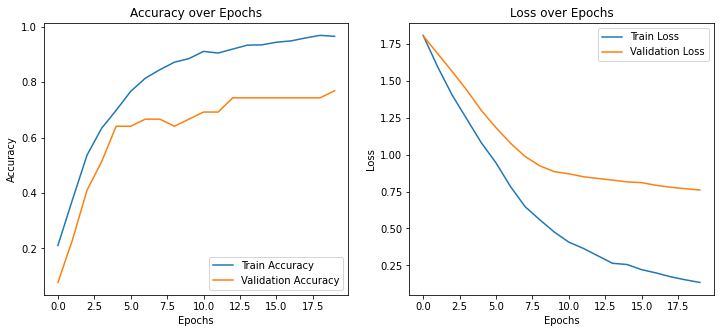

accuracy,▁
epoch/accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▇▇▇▇▇▇▇▇████████
epoch/val_loss,█▇▆▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
loss,▁
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: 1gkqgoqn with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001


Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Epoch 1/30
53/53 [==============================] - 20s 230ms/step - loss: 1.5242 - accuracy: 0.4161 - val_loss: 1.3420 - val_accuracy: 0.6410
Epoch 2/30
53/53 [==============================] - 11s 205ms/step - loss: 0.8817 - accuracy: 0.7530 - val_loss: 0.8716 - val_accuracy: 0.7692
Epoch 3/30
53/53 [==============================] - 11s 212ms/step - loss: 0.5360 - accuracy: 0.8392 - val_loss: 0.7953 - val_accuracy: 0.6667
Epoch 4/30
53/53 [==============================] - 11s 207ms/step - loss: 0.3495 - accuracy: 0.8960 - val_loss: 0.7924 - val_accuracy: 0.6667
Epoch 5/30
53/53 [==============================] - 11s 204ms/step - loss: 0.2364 - accuracy: 0.9255 - val_loss: 0.7148 - val_accuracy: 0.7692
Epoch 6/30
53/53 [==============================] - 11s 203ms/step - loss: 0.2101 - accuracy: 0.9362 - val_loss: 0.6349 - val_accuracy: 0.7436
Epoch 7/30
53/53 [==============================] - 11s 208ms

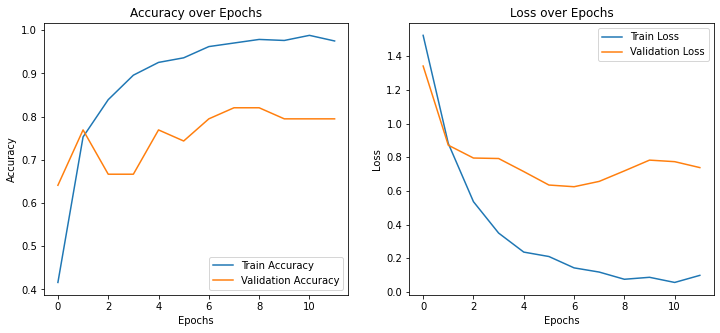

accuracy,▁
epoch/accuracy,▁▅▆▇▇▇██████
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,█████████▁▁▁
epoch/loss,█▅▃▂▂▂▁▁▁▁▁▁
epoch/lr,██████████▁▁
epoch/val_accuracy,▁▆▂▂▆▅▇██▇▇▇
epoch/val_loss,█▃▃▃▂▁▁▁▂▃▂▂
loss,▁
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: wo07fbga with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05


Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Epoch 1/10
53/53 [==============================] - 20s 226ms/step - loss: 1.8986 - accuracy: 0.1761 - val_loss: 1.8734 - val_accuracy: 0.2051
Epoch 2/10
53/53 [==============================] - 11s 205ms/step - loss: 1.8199 - accuracy: 0.2258 - val_loss: 1.8008 - val_accuracy: 0.2308
Epoch 3/10
53/53 [==============================] - 11s 209ms/step - loss: 1.7164 - accuracy: 0.2790 - val_loss: 1.7242 - val_accuracy: 0.2564
Epoch 4/10
53/53 [==============================] - 11s 205ms/step - loss: 1.6264 - accuracy: 0.3676 - val_loss: 1.6553 - val_accuracy: 0.3333
Epoch 5/10
53/53 [==============================] - 11s 207ms/step - loss: 1.5814 - accuracy: 0.3865 - val_loss: 1.5853 - val_accuracy: 0.4103
Epoch 6/10
53/53 [==============================] - 11s 206ms/step - loss: 1.4733 - accuracy: 0.4622 - val_loss: 1.5335 - val_accuracy: 0.5385
Epoch 7/10
53/53 [==============================] - 11s 205ms

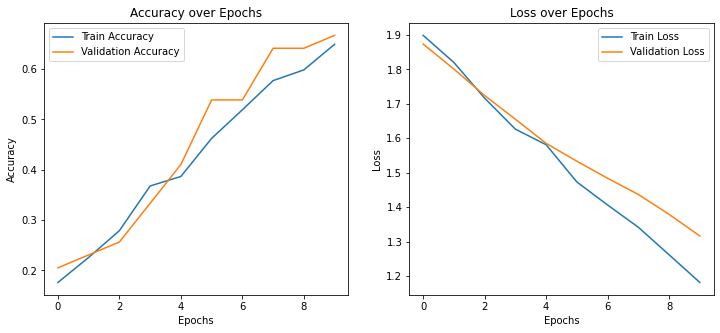

accuracy,▁
epoch/accuracy,▁▂▃▄▄▅▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▃▃▂▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▂▃▄▆▆███
epoch/val_loss,█▇▆▅▄▄▃▃▂▁
loss,▁
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: 6tz8l1md with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05


Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Epoch 1/10
14/14 [==============================] - 21s 904ms/step - loss: 1.9039 - accuracy: 0.1761 - val_loss: 1.8493 - val_accuracy: 0.2051
Epoch 2/10
14/14 [==============================] - 12s 803ms/step - loss: 1.8706 - accuracy: 0.1903 - val_loss: 1.8224 - val_accuracy: 0.2821
Epoch 3/10
14/14 [==============================] - 12s 808ms/step - loss: 1.8322 - accuracy: 0.2045 - val_loss: 1.7921 - val_accuracy: 0.3077
Epoch 4/10
14/14 [==============================] - 12s 808ms/step - loss: 1.7836 - accuracy: 0.2411 - val_loss: 1.7656 - val_accuracy: 0.2821
Epoch 5/10
14/14 [==============================] - 12s 817ms/step - loss: 1.7508 - accuracy: 0.2494 - val_loss: 1.7382 - val_accuracy: 0.2821
Epoch 6/10
14/14 [==============================] - 12s 813ms/step - loss: 1.7014 - accuracy: 0.2730 - val_loss: 1.7087 - val_accuracy: 0.3077
Epoch 7/10
14/14 [==============================] - 12s 799ms

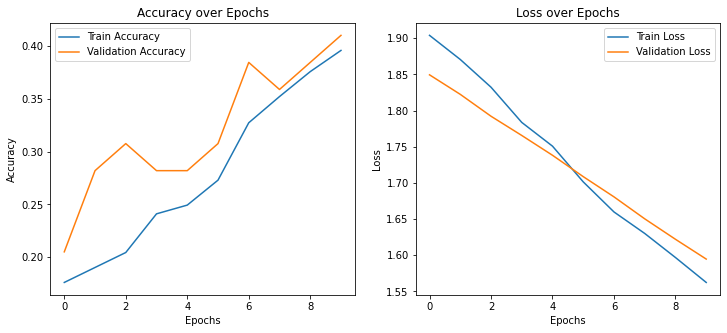

accuracy,▁
epoch/accuracy,▁▁▂▃▃▄▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▄▃▂▂▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▄▄▅▇▆▇█
epoch/val_loss,█▇▆▆▅▄▃▃▂▁
loss,▁
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: 57l96tkg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 5e-05


Found 846 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Epoch 1/10
14/14 [==============================] - 21s 914ms/step - loss: 1.8619 - accuracy: 0.1690 - val_loss: 1.7928 - val_accuracy: 0.2308
Epoch 2/10
14/14 [==============================] - 12s 805ms/step - loss: 1.6118 - accuracy: 0.3652 - val_loss: 1.6916 - val_accuracy: 0.2821
Epoch 3/10
14/14 [==============================] - 12s 865ms/step - loss: 1.4284 - accuracy: 0.5414 - val_loss: 1.5852 - val_accuracy: 0.4103
Epoch 4/10
14/14 [==============================] - 12s 815ms/step - loss: 1.2398 - accuracy: 0.6773 - val_loss: 1.4653 - val_accuracy: 0.4872
Epoch 5/10
14/14 [==============================] - 12s 792ms/step - loss: 1.0549 - accuracy: 0.7612 - val_loss: 1.3246 - val_accuracy: 0.5385
Epoch 6/10
14/14 [==============================] - 12s 808ms/step - loss: 0.8818 - accuracy: 0.8144 - val_loss: 1.1664 - val_accuracy: 0.5641
Epoch 7/10
14/14 [==============================] - 12s 799ms

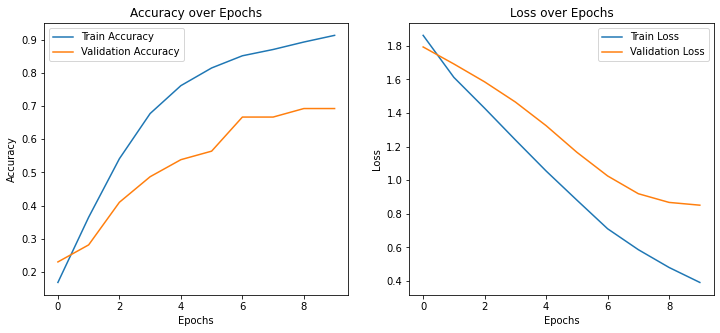

accuracy,▁
epoch/accuracy,▁▃▅▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▂▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▄▅▆▆████
epoch/val_loss,█▇▆▆▅▃▂▂▁▁
loss,▁
test_accuracy,▁
test_loss,▁


In [98]:
# Sweep을 위한 학습 함수
def train_sweep():
    with wandb.init():
        config = wandb.config  # Sweep 하이퍼파라미터 가져오기
        
        # EfficientNetB0 모델 불러오기
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # 새 Fully Connected Layer 추가
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(config.dropout_rate)(x)  # Sweep에서 dropout 값을 자동으로 변경
        x = Dense(6, activation='softmax')(x)

        # 새로운 모델 생성
        model = Model(inputs=base_model.input, outputs=x)

        # EfficientNetB0 일부 레이어만 학습 가능하도록 설정
        for layer in base_model.layers[:-50]:  # 마지막 50개 레이어만 학습
            layer.trainable = True

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=config.learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # 데이터 증강 및 전처리
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        valid_test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')
        val_generator = valid_test_datagen.flow_from_directory(
            valid_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 콜백 함수 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        # 모델 학습
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=config.epochs,
            callbacks=[early_stopping, reduce_lr, WandbMetricsLogger()]
        )
        
        # 🔹 W&B에 loss, accuracy 기록
        wandb.log({
            "loss": history.history["loss"][-1],
            "val_loss": history.history["val_loss"][-1],
            "accuracy": history.history["accuracy"][-1],
            "val_accuracy": history.history["val_accuracy"][-1]
        })

        # 테스트 데이터 불러오기
        test_generator = valid_test_datagen.flow_from_directory(
            test_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 모델 평가
        loss, acc = model.evaluate(test_generator)

        # 🔹 W&B에 테스트 결과 저장
        wandb.log({
            "test_loss": loss,
            "test_accuracy": acc
        })

        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {acc:.4f}")

        # 모델 저장
        model.save(f"efficientnetb0_jellyfish_{wandb.run.name}.h5")

        # 학습 결과 시각화
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.show()

# Sweep 실행
wandb.agent(sweep_id, train_sweep, count=5)

# W&B 종료
wandb.finish()

In [100]:
# W&B API 인스턴스 생성
api = wandb.Api()

entity_name = "aiffel-es-none"  # W&B 계정명 (프로젝트 소유자)
project_name = "jellyfish-classification"  # 프로젝트명

In [102]:
# Sweep 불러오기
sweep_id = "8twrl8wu"  # Sweep ID
sweep = api.sweep(f"{entity_name}/{project_name}/{sweep_id}")

# 최적의 실험 찾기 (validation accuracy 기준)
best_run = max(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0))

# ✅ 최적의 모델 이름
print(f"📌 최적 모델 이름: {best_run.name}")

# ✅ 최적의 하이퍼파라미터 출력
best_params = best_run.config
print(f"\n✅ 최적의 하이퍼파라미터:\n {best_params}")

# ✅ 최적의 모델 성능 출력 (loss, accuracy 등)
best_metrics = best_run.summary
print("\n✅ 최적의 모델 성능:")

# Loss 값은 그대로 출력
print(f"Loss: {best_metrics.get('loss', 'N/A')}")
print(f"Validation Loss: {best_metrics.get('val_loss', 'N/A')}")

# Accuracy 값을 퍼센트로 변환
accuracy = best_metrics.get('accuracy', None)
val_accuracy = best_metrics.get('val_accuracy', None)

if accuracy is not None:
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("Accuracy: N/A")

if val_accuracy is not None:
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
else:
    print("Validation Accuracy: N/A")

📌 최적 모델 이름: fanciful-sweep-2

✅ 최적의 하이퍼파라미터:
 {'epochs': 30, 'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.0001}

✅ 최적의 모델 성능:
Loss: 0.09815017133951189
Validation Loss: 0.7384576797485352
Accuracy: 97.52%
Validation Accuracy: 79.49%


## 2. Dense 512

### 2-1. sweep ID: qlgomcrf

In [103]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish-classification")

Create sweep with ID: qlgomcrf
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish-classification/sweeps/qlgomcrf


In [105]:
# Sweep 불러오기
sweep_id = "qlgomcrf"  # Sweep ID
sweep = api.sweep(f"{entity_name}/{project_name}/{sweep_id}")

# 최적의 실험 찾기 (validation accuracy 기준)
best_run = max(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0))

# ✅ 최적의 모델 이름
print(f"📌 최적 모델 이름: {best_run.name}")

# ✅ 최적의 하이퍼파라미터 출력
best_params = best_run.config
print(f"\n✅ 최적의 하이퍼파라미터:\n {best_params}")

# ✅ 최적의 모델 성능 출력 (loss, accuracy 등)
best_metrics = best_run.summary
print("\n✅ 최적의 모델 성능:")

# Loss 값은 그대로 출력
print(f"Loss: {best_metrics.get('loss', 'N/A')}")
print(f"Validation Loss: {best_metrics.get('val_loss', 'N/A')}")

# Accuracy 값을 퍼센트로 변환
accuracy = best_metrics.get('accuracy', None)
val_accuracy = best_metrics.get('val_accuracy', None)

if accuracy is not None:
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("Accuracy: N/A")

if val_accuracy is not None:
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
else:
    print("Validation Accuracy: N/A")

📌 최적 모델 이름: wise-sweep-5

✅ 최적의 하이퍼파라미터:
 {'epochs': 10, 'batch_size': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0001}

✅ 최적의 모델 성능:
Loss: 0.06542801111936569
Validation Loss: 0.6331390738487244
Accuracy: 98.35%
Validation Accuracy: 84.62%


### 2-2. sweep ID: hj9wcom8

In [112]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish-classification")

Create sweep with ID: hj9wcom8
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish-classification/sweeps/hj9wcom8


In [115]:
# Sweep 불러오기
sweep_id = "hj9wcom8"  # Sweep ID
sweep = api.sweep(f"{entity_name}/{project_name}/{sweep_id}")

# 최적의 실험 찾기 (validation accuracy 기준)
best_run = max(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0))

# ✅ 최적의 모델 이름
print(f"📌 최적 모델 이름: {best_run.name}")

# ✅ 최적의 하이퍼파라미터 출력
best_params = best_run.config
print(f"\n✅ 최적의 하이퍼파라미터:\n {best_params}")

# ✅ 최적의 모델 성능 출력 (loss, accuracy 등)
best_metrics = best_run.summary
print("\n✅ 최적의 모델 성능:")

# Loss 값은 그대로 출력
print(f"Loss: {best_metrics.get('loss', 'N/A')}")
print(f"Validation Loss: {best_metrics.get('val_loss', 'N/A')}")

# Accuracy 값을 퍼센트로 변환
accuracy = best_metrics.get('accuracy', None)
val_accuracy = best_metrics.get('val_accuracy', None)

if accuracy is not None:
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("Accuracy: N/A")

if val_accuracy is not None:
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
else:
    print("Validation Accuracy: N/A")

📌 최적 모델 이름: whole-sweep-4

✅ 최적의 하이퍼파라미터:
 {'epochs': 30, 'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 5e-05}

✅ 최적의 모델 성능:
Loss: 0.07280300557613373
Validation Loss: 0.7122751474380493
Accuracy: 98.23%
Validation Accuracy: 79.49%


# 최적의 하이퍼파라미터

In [116]:
# W&B Sweep 설정 (하이퍼파라미터 검색)
sweep_config = {
    "method": "grid",  # 모든 조합을 시도하려면 "grid", 무작위 탐색은 "random"
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [0.0001]},
        "batch_size": {"values": [16]}, 
        "dropout_rate": {"values": [0.2]}, 
        "epochs": {"values": [10]} 
    },
}

In [117]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish-classification")

Create sweep with ID: 41ylw4po
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish-classification/sweeps/41ylw4po


In [122]:
# Sweep 불러오기
sweep_id = "41ylw4po"  # Sweep ID
sweep = api.sweep(f"{entity_name}/{project_name}/{sweep_id}")

# ✅ Loss 및 Accuracy 출력
print(f"Loss: {best_metrics.get('loss', 'N/A')}")
print(f"Validation Loss: {best_metrics.get('val_loss', 'N/A')}")

accuracy = best_metrics.get('accuracy', None)
val_accuracy = best_metrics.get('val_accuracy', None)

if accuracy is not None:
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("Accuracy: N/A")

if val_accuracy is not None:
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
else:
    print("Validation Accuracy: N/A")

Loss: 0.07280300557613373
Validation Loss: 0.7122751474380493
Accuracy: 98.23%
Validation Accuracy: 79.49%
